In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-predictionused-cars/car data.csv


# Car Price Prediction with Machine Learning Project

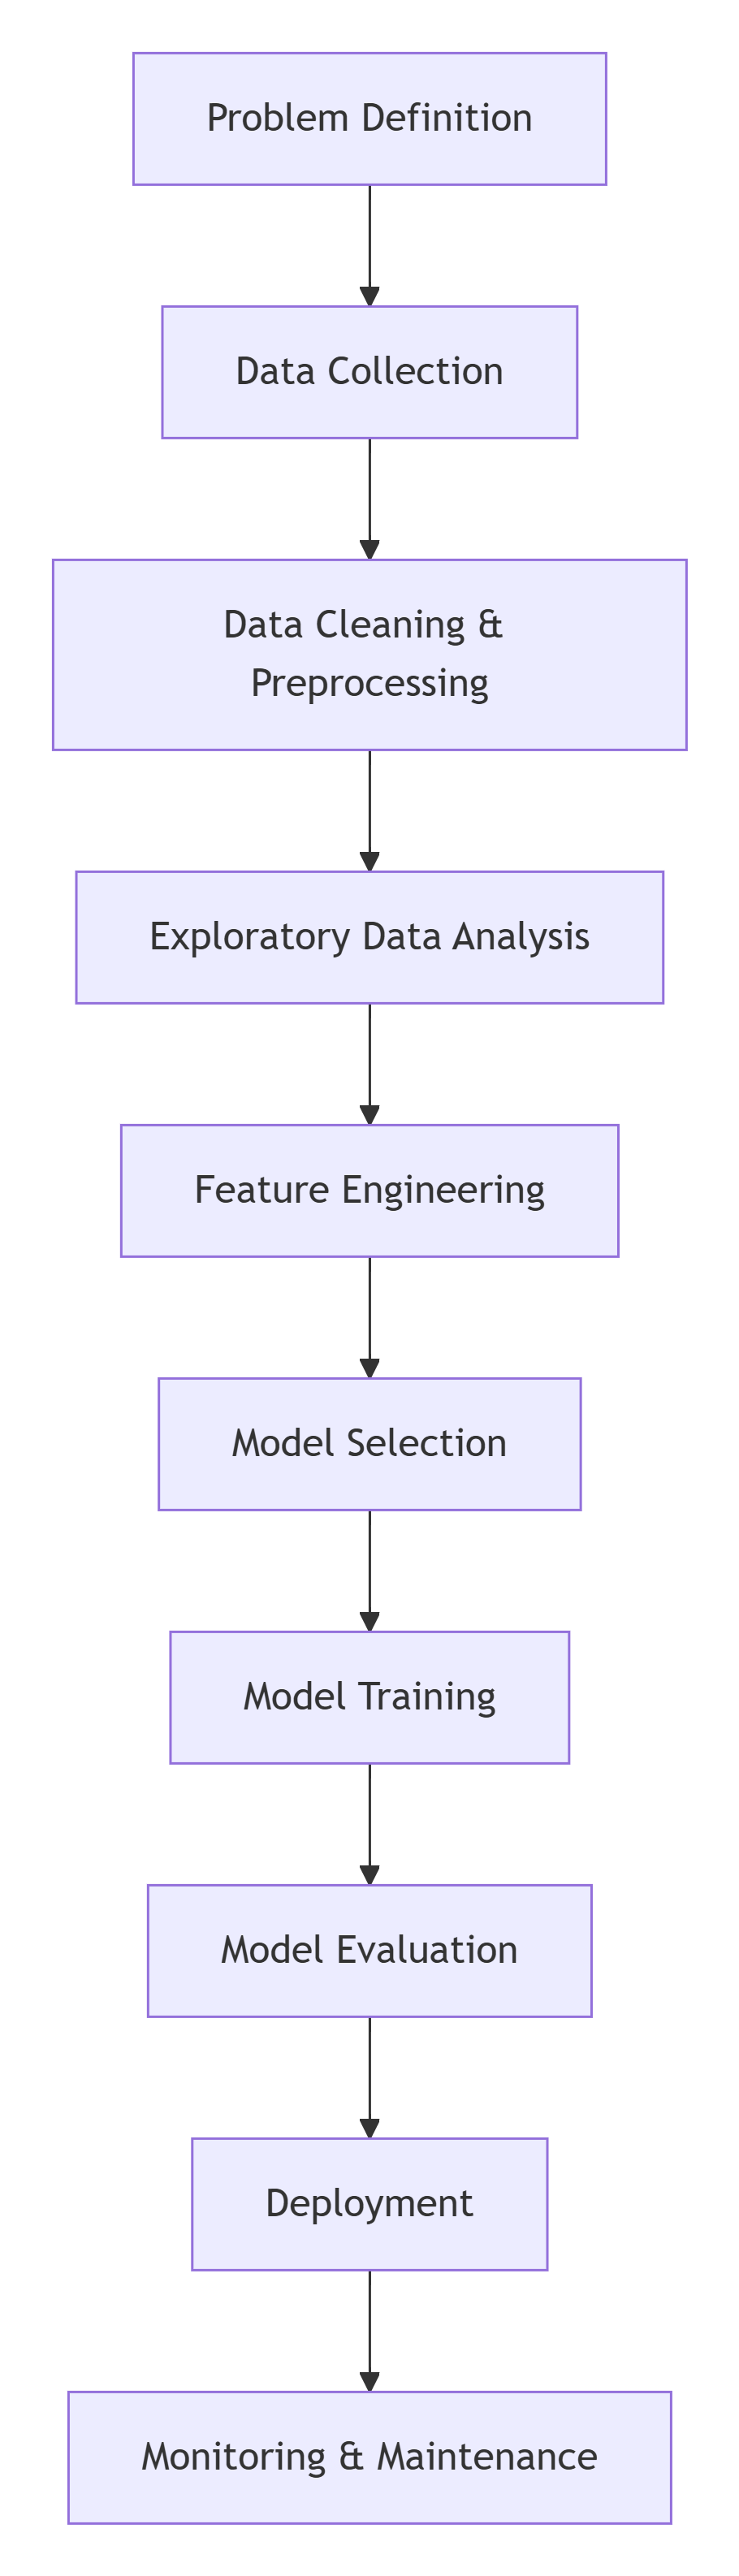

## 1. Data Loading and Initial Exploration

In [21]:
# 1. Data Loading and Initial Exploration (Same as before)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/kaggle/input/car-price-predictionused-cars/car data.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (301, 9)

First 5 rows:
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  


## 2. Exploratory Data Analysis

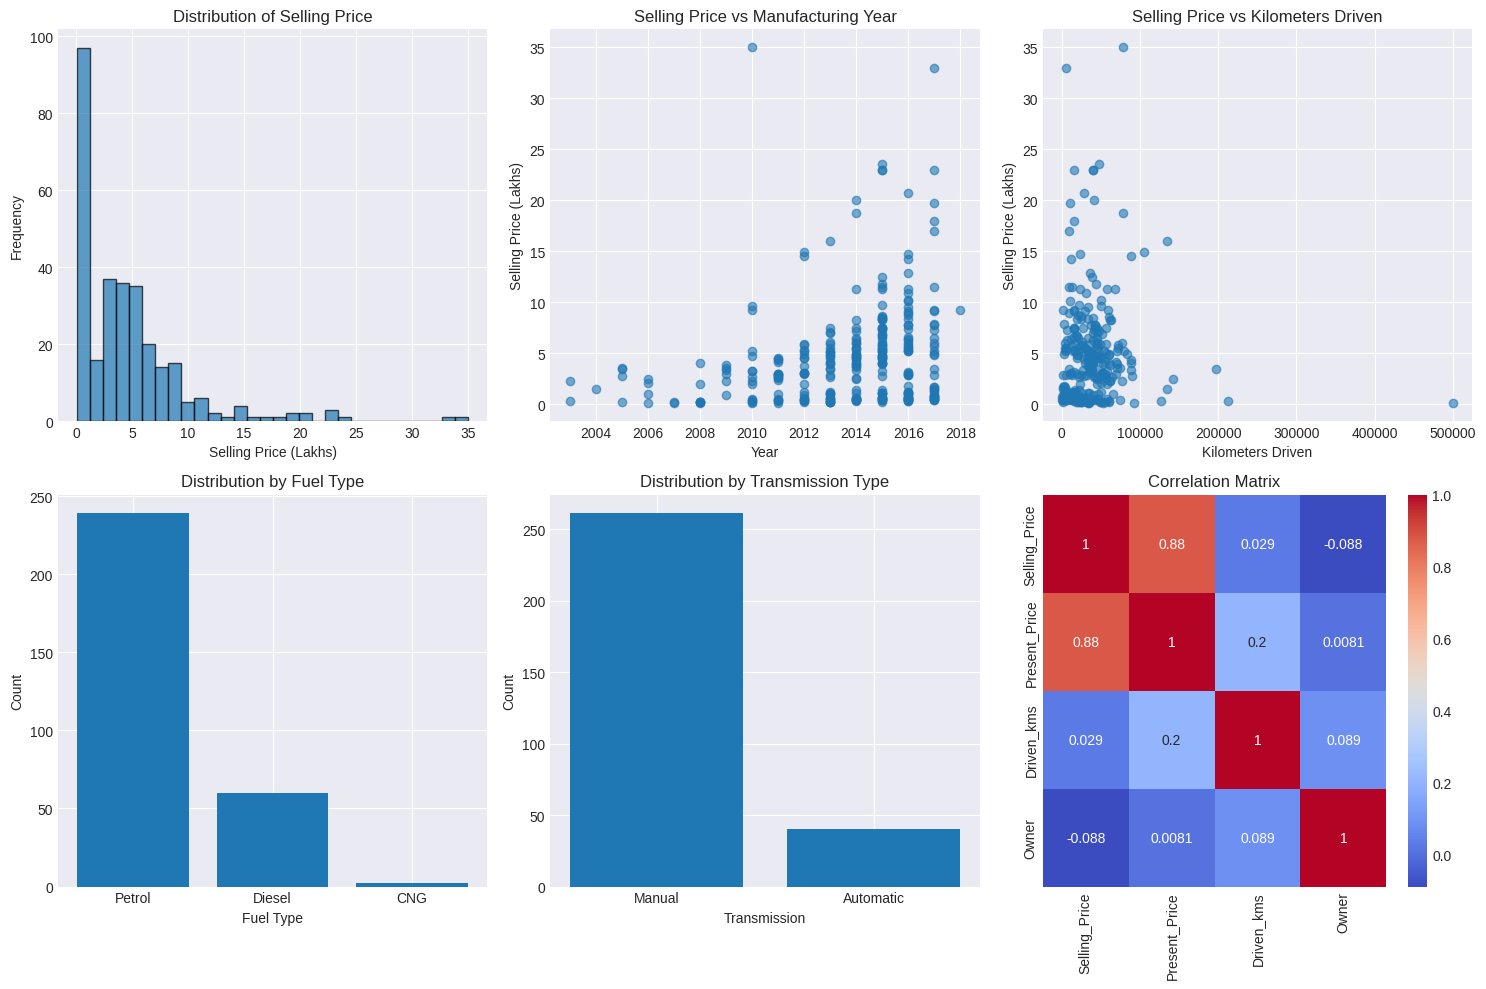

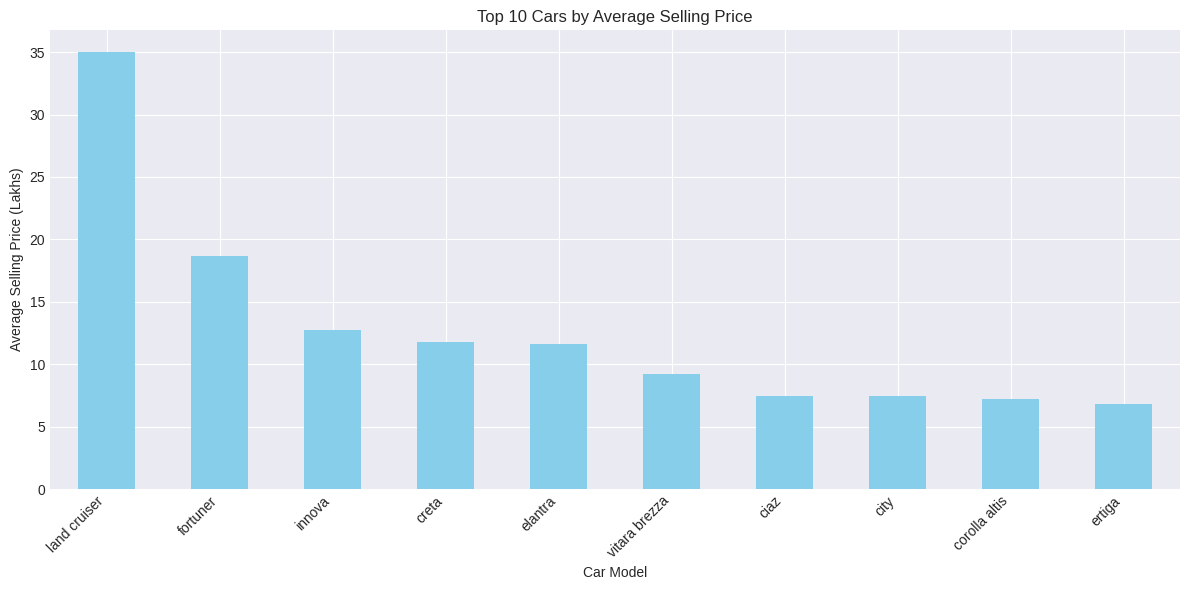

In [22]:
# Set up the visualization style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Distribution of Selling Price
axes[0, 0].hist(df['Selling_Price'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Selling Price')
axes[0, 0].set_xlabel('Selling Price (Lakhs)')
axes[0, 0].set_ylabel('Frequency')

# 2. Selling Price vs Car Age
axes[0, 1].scatter(df['Year'], df['Selling_Price'], alpha=0.6)
axes[0, 1].set_title('Selling Price vs Manufacturing Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Selling Price (Lakhs)')

# 3. Selling Price vs Kilometers Driven
axes[0, 2].scatter(df['Driven_kms'], df['Selling_Price'], alpha=0.6)
axes[0, 2].set_title('Selling Price vs Kilometers Driven')
axes[0, 2].set_xlabel('Kilometers Driven')
axes[0, 2].set_ylabel('Selling Price (Lakhs)')

# 4. Fuel Type Distribution
fuel_counts = df['Fuel_Type'].value_counts()
axes[1, 0].bar(fuel_counts.index, fuel_counts.values)
axes[1, 0].set_title('Distribution by Fuel Type')
axes[1, 0].set_xlabel('Fuel Type')
axes[1, 0].set_ylabel('Count')

# 5. Transmission Type
transmission_counts = df['Transmission'].value_counts()
axes[1, 1].bar(transmission_counts.index, transmission_counts.values)
axes[1, 1].set_title('Distribution by Transmission Type')
axes[1, 1].set_xlabel('Transmission')
axes[1, 1].set_ylabel('Count')

# 6. Correlation Heatmap
correlation_cols = ['Selling_Price', 'Present_Price', 'Driven_kms', 'Owner']
corr_matrix = df[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1, 2])
axes[1, 2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Additional EDA: Top 10 cars by average price
top_cars = df.groupby('Car_Name')['Selling_Price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_cars.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cars by Average Selling Price')
plt.xlabel('Car Model')
plt.ylabel('Average Selling Price (Lakhs)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Feature Engineering

In [23]:
# Create a copy for preprocessing
df_clean = df.copy()

# 1. Calculate car age instead of year
current_year = 2024  # Update based on current year
df_clean['Car_Age'] = current_year - df_clean['Year']

# 2. Drop the Year column as we now have age
df_clean = df_clean.drop('Year', axis=1)

# 3. Extract brand name from Car_Name (optional, for analysis)
df_clean['Brand'] = df_clean['Car_Name'].apply(lambda x: str(x).split()[0])

# 4. Let's see what unique values we have in categorical columns
print("\nUnique values in categorical columns:")
for col in ['Fuel_Type', 'Selling_type', 'Transmission']:
    print(f"{col}: {df_clean[col].unique()}")

# 5. Identify numeric and categorical columns
numeric_features = ['Present_Price', 'Driven_kms', 'Car_Age', 'Owner']
categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission']

# For initial modeling, let's drop Car_Name and Brand as they have too many categories
df_model = df_clean.drop(['Car_Name', 'Brand'], axis=1)

# 6. Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

print("\nAfter preprocessing - First 5 rows:")
print(df_model.head())


Unique values in categorical columns:
Fuel_Type: ['Petrol' 'Diesel' 'CNG']
Selling_type: ['Dealer' 'Individual']
Transmission: ['Manual' 'Automatic']

After preprocessing - First 5 rows:
   Selling_Price  Present_Price  Driven_kms  Fuel_Type  Selling_type  \
0           3.35           5.59       27000          2             0   
1           4.75           9.54       43000          1             0   
2           7.25           9.85        6900          2             0   
3           2.85           4.15        5200          2             0   
4           4.60           6.87       42450          1             0   

   Transmission  Owner  Car_Age  
0             1      0       10  
1             1      0       11  
2             1      0        7  
3             1      0       13  
4             1      0       10  


## 4. Feature Selection and Train-Test Split


In [24]:
# Define features and target
X = df_model.drop('Selling_Price', axis=1)
y = df_model['Selling_Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Check data types
print("\nData types in X_train:")
print(X_train.dtypes)

# Feature scaling (only on numeric columns)
scaler = StandardScaler()

# Fit on numeric features only
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numeric columns
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("\nScaling completed successfully!")

Training set size: (240, 7)
Testing set size: (61, 7)

Data types in X_train:
Present_Price    float64
Driven_kms         int64
Fuel_Type          int64
Selling_type       int64
Transmission       int64
Owner              int64
Car_Age            int64
dtype: object

Scaling completed successfully!


## 5. Advanced Preprocessing with Pipeline


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Reload and preprocess from scratch
df_clean2 = df.copy()
df_clean2['Car_Age'] = current_year - df_clean2['Year']
df_clean2 = df_clean2.drop(['Year', 'Car_Name'], axis=1)

# Split data
X = df_clean2.drop('Selling_Price', axis=1)
y = df_clean2['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column types
numeric_features = ['Present_Price', 'Driven_kms', 'Car_Age', 'Owner']
categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed testing shape: {X_test_processed.shape}")

Processed training shape: (240, 8)
Processed testing shape: (61, 8)


## 6. Model Training and Evaluation


In [26]:
# Model training with corrected data
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    }
    
    print(f"\n{name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Create a comparison DataFrame
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df)


Linear Regression Results:
MAE: 1.2164
MSE: 3.4813
RMSE: 1.8658
R2 Score: 0.8489

Ridge Regression Results:
MAE: 1.2140
MSE: 3.4759
RMSE: 1.8644
R2 Score: 0.8491

Lasso Regression Results:
MAE: 1.2538
MSE: 3.6756
RMSE: 1.9172
R2 Score: 0.8404

Random Forest Results:
MAE: 0.6191
MSE: 0.8753
RMSE: 0.9356
R2 Score: 0.9620

Gradient Boosting Results:
MAE: 0.5907
MSE: 0.8958
RMSE: 0.9465
R2 Score: 0.9611

MODEL COMPARISON
                        MAE       MSE      RMSE  R2 Score
Linear Regression  1.216374  3.481350  1.865838  0.848871
Ridge Regression   1.213991  3.475945  1.864389  0.849105
Lasso Regression   1.253811  3.675641  1.917196  0.840436
Random Forest      0.619097  0.875280  0.935564  0.962003
Gradient Boosting  0.590686  0.895804  0.946469  0.961112


## 7. Feature Importance Analysis


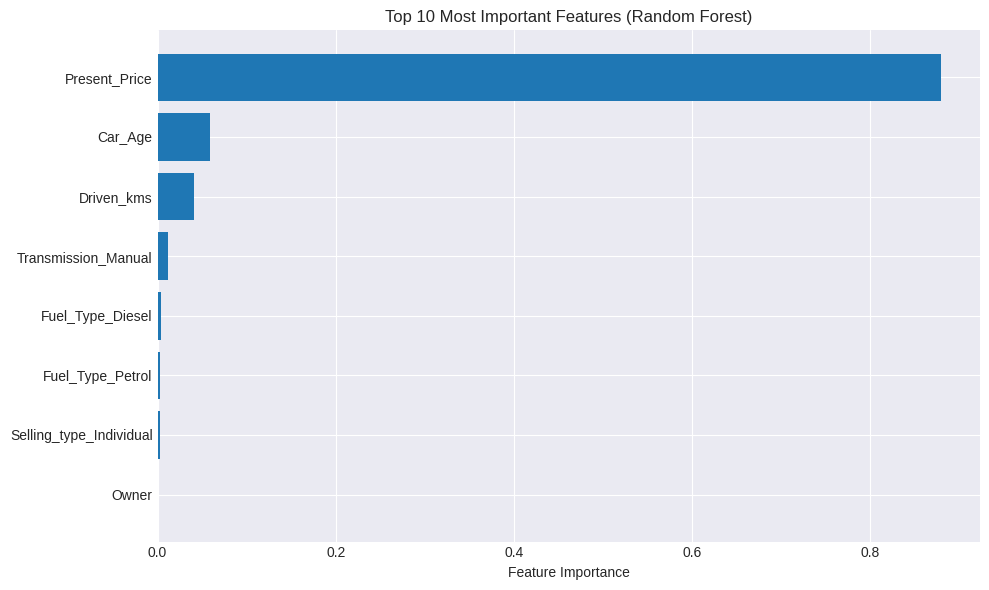

In [27]:
# Get feature importance from Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        # Get feature names from one-hot encoding
        onehot = trans.named_steps['onehot']
        cat_features = onehot.get_feature_names_out(cols)
        feature_names.extend(cat_features)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Model Visualization and Insights


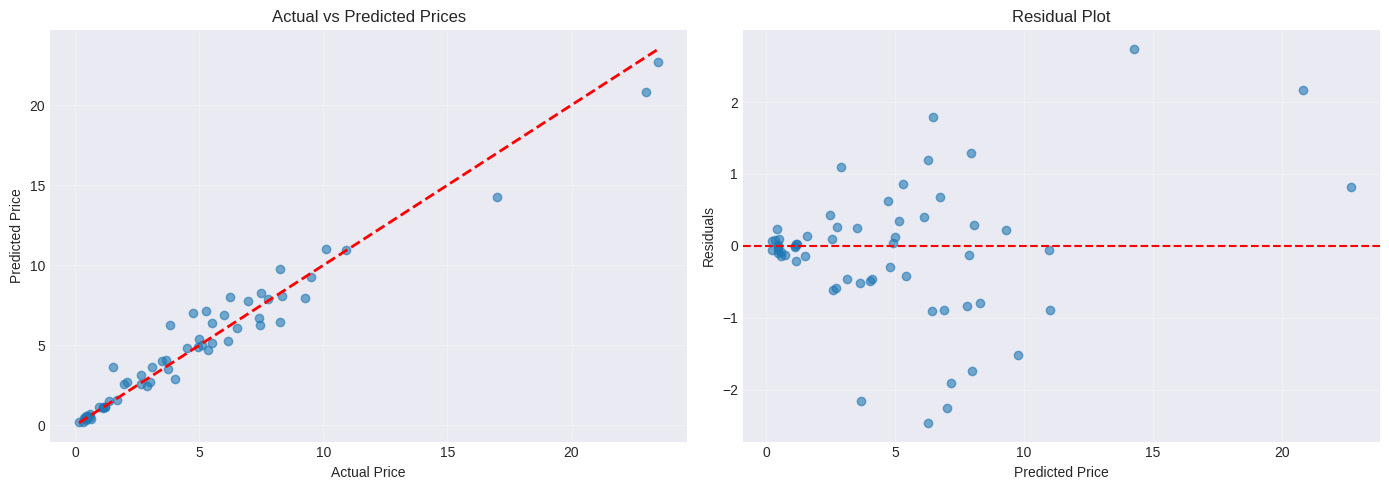

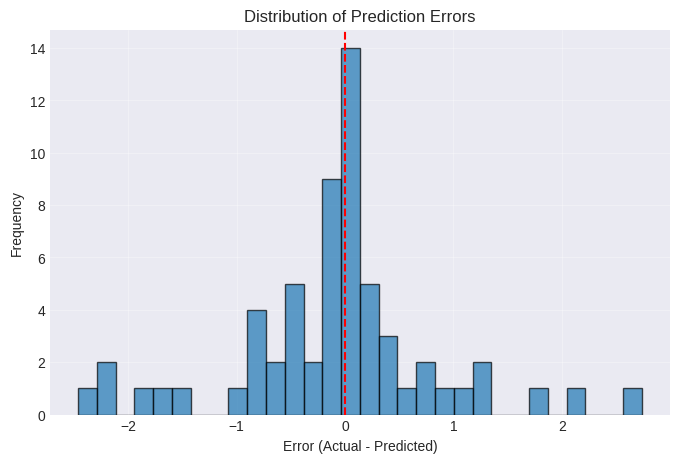

In [28]:
# Visualize predictions vs actual values
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train_processed, y_train)
y_pred = best_model.predict(X_test_processed)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Actual vs Predicted Prices')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 9. Prediction Function


In [29]:
def predict_car_price(model, preprocessor, input_features):
    """
    Predict car price based on input features
    
    Parameters:
    model: Trained ML model
    preprocessor: Fitted preprocessing pipeline
    input_features: Dictionary of feature values
    
    Returns:
    Predicted price in lakhs
    """
    
    # Create a DataFrame from input features
    input_df = pd.DataFrame([input_features])
    
    # Apply same preprocessing as training
    input_processed = preprocessor.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_processed)[0]
    
    return round(prediction, 2)

# Example usage
example_car = {
    'Present_Price': 10.0,
    'Driven_kms': 50000,
    'Fuel_Type': 'Petrol',
    'Selling_type': 'Dealer',
    'Transmission': 'Manual',
    'Owner': 0,
    'Car_Age': 5
}

predicted_price = predict_car_price(best_model, preprocessor, example_car)
print(f"\nPredicted selling price for example car: ₹{predicted_price} lakhs")


Predicted selling price for example car: ₹7.83 lakhs


## 10. Save the Model for Future Use


In [30]:
import joblib
import pickle

# Save the complete pipeline including preprocessing
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Train the pipeline on full training data
model_pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(model_pipeline, 'car_price_predictor_pipeline.pkl')
print("Model pipeline saved successfully as 'car_price_predictor_pipeline.pkl'")

# Also save preprocessor and model separately
model_data = {
    'preprocessor': preprocessor,
    'model': best_model,
    'feature_columns': list(X.columns)
}

with open('car_price_model_complete.pickle', 'wb') as f:
    pickle.dump(model_data, f)
print("Complete model data saved as 'car_price_model_complete.pickle'")


Model pipeline saved successfully as 'car_price_predictor_pipeline.pkl'
Complete model data saved as 'car_price_model_complete.pickle'


In [31]:
# QUICK FIX: Convert all columns to numeric (handle errors by coercing)
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')

# Fill any NaN values that might have been created
X_train_numeric = X_train_numeric.fillna(0)
X_test_numeric = X_test_numeric.fillna(0)

# Now scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

print("Scaling successful with quick fix!")

Scaling successful with quick fix!
